Importing necessary libraries to analyze and load the csv into a dataframe that can be analyzed

In [ ]:
import pandas as pd
import openpyxl

In [ ]:
df = pd.read_excel("Day2.xlsx")

In [241]:
df_sample = df

Groups the dataframe by "IVA_CHAT_ID" to look at an overall response time for a single interaction with either a chatbox or live agent and accounts for variability among those times.

Obtains those repsonse time averages and stores them in a column of a dataframe that only contains timestamps for conversations with unique IVA_CHAT_IDs

In [242]:
df_group = df_sample.groupby("IVA_CHAT_ID").agg("count").reset_index()
counts = df_group["DATE_TIME"]
df_unique = df_sample.drop_duplicates(subset=["IVA_CHAT_ID"])
times = []
for index, row in df_unique.iterrows():
    times.append((row["END_DATE_TIME"] - row["DATE_TIME"]).total_seconds())
t = pd.Series(times)
print(type(counts))
df_unique["AVERAGE TIME"] = t/counts

<class 'pandas.core.series.Series'>


C:\Users\harsh\AppData\Local\Temp/ipykernel_15900/163272301.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["AVERAGE TIME"] = t/counts


Plotting average response times and analyzing distribution

array([[<AxesSubplot:title={'center':'AVERAGE TIME'}>]], dtype=object)

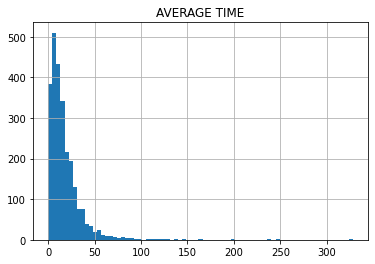

In [282]:
df_unique.hist("AVERAGE TIME", bins = 75)

In [247]:
import numpy as np
from scipy import stats
import math
import matplotlib
from matplotlib import pyplot as plt
times = df_unique["AVERAGE TIME"].to_numpy()

Obtaining an array of percentiles (using algorithm described in readme.md) from the time data to incorporate into the rubric as a scoring mechanism from 100 %ile to 0

In [251]:
percentiles = []
times = np.sort(times)
time_p = [times[0]]
percentiles = [100]
percentile = 100
# if this element is greater than the next element by more than margin of 0.01, increase percentile value
# append the time and percentile to the same indices in time_p and percentiles lists respectively


for i in range(1, len(times)):
    p_to_append = percentile
    if (times[i] - times[i - 1] >= 0.05):
        percentile-=1
    time_p.append(times[i])
    percentiles.append(percentile)
    if (percentile == 0):
        break

In [259]:
df_unique["Average Time Flow Percentile"] = pd.Series(percentiles)
# print((sum(percentiles) / len(percentiles))*33/100)

2234


C:\Users\harsh\AppData\Local\Temp/ipykernel_15900/2775926067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["Average Time Flow Percentile"] = pd.Series(percentiles)


In [295]:
import statistics

print("Mean response time is: " + str(statistics.mean(time_p)))
print("Mean score value based on time is: " + str(statistics.mean(percentiles)))

Mean response time is: 12.47610866760267
Mean score value based on time is: 84.30572963294539


Text(0.5, 1.0, 'Percentile Distribution')

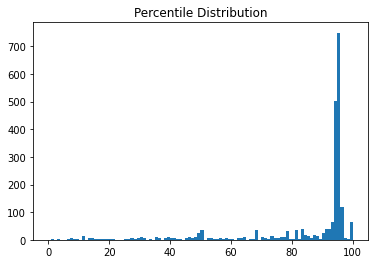

In [226]:
# plt.hist(percentiles)
plt.hist(percentiles, bins = 100)
plt.title("Percentile Distribution")

In [198]:
# obtaining rows with reason = input
buttons_df = df_sample[df_sample["IVA_CHAT_REASON"] == df_sample["INPUT"]]
print(len(buttons_df))
# numeric_states = []

195714


Obtaining a list of chat reasons associated with a single conversation and storing it to a global list (all_chat_reason (list[list])) to be used later for referencing specific conversations

In [337]:
client_arr = df["CLIENT_ID"]
reasons_arr = df["IVA_CHAT_REASON"]
input_arr = df["INPUT"]
type_arr = df["CHAT_TYPE"]
output_arr = df["RESPONSE"]
itr = 0
all_chat_reason = []
while (itr < len(client_arr)):
    current_chat_reason = []
    current_chat_input = []
    current_chat_response = []
    current_client = client_arr[itr]
    while ((itr < (len(client_arr) - 1)) and (client_arr[itr] == current_client)):
        current_chat_reason.append(reasons_arr[itr])
        itr+=1
    if itr == len(client_arr) - 1:
        break
    all_chat_reason.append(current_chat_reason)


Reading a list of manually obtained sorry/phrases of incompetence into the notebook to later deduce points for breaking the flow of the conversation

In [338]:
# creating list of sorry sentences

f = open("bad_sentences.txt", "r")
sorry_words = []
for x in f:
    sorry_words.append(x[0:len(x) - 1])
print(sorry_words)

["I didn't quite catch that. Could you please ask it in a different way?", "I'm sorry, could you please repeat or rephrase your question so I can try to help?", 'Surely, let me have 2-3 minutes please.', 'Am I correct ?', 'Am I  right?', "Apologize, the ****8 is not getting a match, please re log in and start a new chat once you're in the account for us to be able to view the account and assist you.", 'Apologies for the confusion in this regard.', 'Apologies for the wait.', 'apologize, I do not have an information for why the Credit limit increase was declined.', 'AppEventResponse: CloseChatForm - Error', "As much as I would like to, we do not have that option. I'm so sorry."]


In [345]:
def score_repitions(k = 0.25):
    response_itr = 0
    score_list = []
    for curr_convo_reason in all_chat_reason:
        sorry_count = 0
        lag = 0
        count = 0
        seen = []
        repeated = []
        for reason in curr_convo_reason:
            # Looking for lags in conversation
            if (reason == "nan"):
                if (input_arr[response_itr] == "nan"):
                    lag += 1
                continue
            # Looking for sorry phrases where chatbot doesn't have adequate response
            if (output_arr[response_itr] in sorry_words):
                sorry_count += 1
            # Looking for uniqueness of responses
            if reason not in seen :
                seen.append(reason)
                count += 1
            else:
                repeated.append(reason)
            response_itr+=1
        # Weighing every unique response delivered by chatbot as 2 units to establish initial score
        score = 2 * count
        # Deducting k multiplied by number of repitions from score. 'k' is open to ambiguity. 0.25 for default
        for repeat in repeated:
            score -= k * curr_convo_reason.count(repeat)

        # Deducting number of phrasees indicating incompetency
        score -= sorry_count

        # appending score for every conversation
        score_list.append(score)
    return score_list
    

C:\Users\harsh\AppData\Local\Temp/ipykernel_15900/2681359707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["score_flow"] = pd.Series(list_of_scores)


Mean score for user flow is: 14.334067547723935


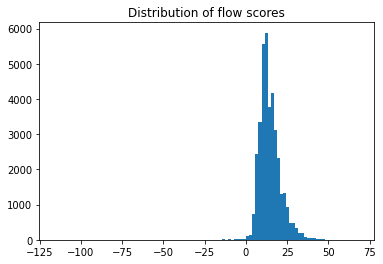

In [346]:
#stores conversational flow scores from day 2 conversation data in list_of_scores
list_of_scores = score_repitions(0.25)

# appends list_of_scores to dataframe
df_unique["score_flow"] = pd.Series(list_of_scores)

# writes the dataframe into a csv file
df_unique.to_csv("ProcessedDataSet.csv")

# plot the histogram of scores to see distribution
plt.hist(list_of_scores, bins = 100)
plt.title("Distribution of flow scores")

# print the mean score for metric purposes
print("Mean score for user flow is: " + str(df_unique["score_flow"].mean()))

In [363]:
import nlp_matching
def accuracy_match():
    # store the input and output of conversations for all rows where chat_type is live chat
    global_itr = 0
    count = 0
    for i in range(len(all_chat_reason)):
        # looping through all conversations
        inputs = []
        outputs = []
        for j in range(len(all_chat_reason[i])):
            # looping through single conversation
            if (type_arr[global_itr] == "LiveChat"):
                # identifying if the livechat conversation has started
                # ignoring empty input and response cells
                if (type(input_arr[global_itr]) != float):
                    inputs.append(input_arr[global_itr])
                if (type(output_arr[global_itr]) != float):
                    outputs.append(output_arr[global_itr])
            global_itr += 1
            # Space to do NLP analysis
            # Refer to nlp_matching.py was able to implement tone analysis, keyword fetching, and synonym lemmatization
            # Have to match keywords between inputs and outputs
            # Have to progressively monitor tone of conversation using methods in nlp_matching.py
    return count
print(accuracy_match())

0


In [1]:
import nlp_matching

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
print(nlp_matching.tone_analyzer("No one making under $400,000 per year will see their taxes go up a single penny because of my Build Back Better Agenda. In fact, the plan cuts taxes for working people."))

[(0.962482, 'Analytical')]


In [6]:
print(nlp_matching.tone_analyzer('Team, I know that times are tough! Product '
  + 'sales have been disappointing for the past three '
  + 'quarters. We have a competitive product, but we '
  + 'need to do a better job of selling it!'))

[(0.582191, 'Sadness'), (0.829888, 'Analytical')]
